![banner](./images/banner.png "banner")

[Fuente de la imagen](https://unsplash.com/photos/Hcfwew744z4)
<a name='toc' />

# <font color=#ac6240>Explicabilidad de la predicción de fallo cardíaco con aprendizaje automático supervisado</font>

### <font color=#ac6240>Tabla de Contenidos</font>

<a href=#pre>Requisitos previos</a><br>
1. <a href=#project-description>Descripción del proyecto de explicabilidad</a><br>
    1.1 <a href=#project-description-goal>Objetivo</a><br>
    1.2 <a href=#project-description-data>Datos y modelos</a><br>
    1.3 <a href=#project-description-software>Software</a><br>
2. <a href=#prep>Preparación de los datos</a><br>
    2.1 <a href=#prep-clean> Limpieza de los datos</a><br>
    2.2 <a href=#prep-split> Division de los datos en conjuntos de datos de entrenamiento, validación y prueba</a><br>
    2.3 <a href=#prep-conding> Codificación de las variables categóricas</a><br>
    2.4 <a href=#prep-scaling> Normalización de las variables numéricas</a><br>
3. <a href=#model>Bosque aleatorio</a><br>
    3.1 <a href=#model-metric> Selección de la métrica y del umbral de decisión </a><br>
    3.2 <a href=#model-RF> Entrenamiento, prueba, y aplicación del modelo </a><br>
4. <a href=#xai-app>Aplicación del modelos de explicabilidad</a><br>
    4.1 <a href=#xai-per> Permutacion importance</a><br>
    4.2 <a href=#xai-shap> SHAP </a><br>
    4.3 <a href=#xai-lime> LIME </a><br>

<a name='pre'/>

## <font color=#ac6240>Requisitos previos</font>

Este Jupyter Notebook es la continuación del Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI). En ese otro estudio explicamos cómo explorar exhaustivamente los datos y cómo evaluar la calidad de un modelo. Para esto último utilizamos métricas de rendimiento o desempeño sobre varios modelo de aprendizaje automático supervisado y elegimos el que mejor se comportaba para este proyecto de predicción de fallo cardíaco con aprendizaje automático supervisado.

<font size="5"> 👍🤓 </font>

<a name='project-description'/>

##  <font color=#ac6240>1. Descripción del proyecto de explicabilidad</font>

Una vez el modelo de aprendizaje automático está entrenado y nos ha dado como resultado sus predicciones, a menudo es fundamental entender en qué se fijó el modelo para hacer tales predicciones. Esto nos asegura que se llevó a cabo la tarea que deseamos y no otra. Por ejemplo, si estamos clasificando fotos de animales, es importante comprobar que el modelo ha identificado un caballo o una yegua por su forma, y no porque hizo trampas y descubrió que le era más facil leer la marca de agua de lx proveedorx de las fotos (no es broma, [aquí un ejemplo](https://www.nature.com/articles/s41467-019-08987-4)). Esto es fundamental porque probablemente cuando apliquemos el modelo en la vida real, las nuevas fotos que vea el modelo no lleven esa marca de agua y por lo tanto ese modelo será inútil. 

![horse-LRP](./images/horse_LRP.png "horse_LRP")

[Fuente de la imagen](https://www.nature.com/articles/s41467-019-08987-4)

#### <font color=#ac6240>Qué es la explicabilidad</font>

Un cambio inesperado e indeseado de tarea (en el ejemplpo anterior, queríamos un modelo que identificara animales, no etiquetas con nombres de animales) puede pasar desapercivido, sobre todo si el modelo no es interpretable por las personas (como son las redes neuronales que se utilizan para clasificar imagenes).  Para evitar que esto ocurra podemos aplicar técnicas de explicabilidad, también conocidas como [XAI](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence), sobre los resultados del modelo y comprobar, por ejemplo, si durante el entrenamiento hubo percolaciones de información indeseadas, un fenómeno llamado [leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning). 

Es decir, podemos aplicar métodos de XAI a los resultados de un modelo ya entrenado para ver qué variables afectan a dichos resultados (y por lo tanto fueron importantes para el modelo) y cuáles no. Es importante resaltar que una variable puede ser importante para un modelo pero para otro no, es decir, los métodos de XAI no nos dan el poder predictivo de las variables de manera absoluta, si no de manera relativa respecto a ese modelo que nos dió ese resultado.

En la figura anterior, vemos a la derecha el resultado de la aplicación del método de XAI llamado Layerlayer-wise relevance propagation (LRP) que descubrió que el modelo de clasificación de imágenes no se fijaba en el caballo o yegua de la imagen sino en una marca del agua de la empresa que proporcionaba las fotografías de caballos ("Pferde" en alemán), muy loco <font size="5">🤪</font>.

#### <font color=#ac6240>Algunas definiciones sobre explicabilidad</font>

+ Modelos caja negra o 'Black-box models':
No son modelos interpretables, las personas no pueden comprender las causas de las decisiones porque (i) conociendo los valores de los parámetros e hiperpárametros de una caja negra no es suficiente para inferir que es lo que ocurre o (ii) las asumpciones y limitaciones subyacentes del modelo son desconocidas. Ejemplos de modelos caja negra son: los bosques aleatorios y sus versiones secuenciadas y aceleradas ('gradient-boosted') y todas las redes neuronales.


+ Modelos explicables:
Aun son cajas negras, no interpretables, pero con algunos metodos de explicabilidad o XAI intentamos entender de dónde vienen las prediciones y por que se tomaron esas decisiones y no otras. Estas técnicas de XAI están basadas sobre todo en modelos subrogados y agnósticos que se aplican post-hoc, es decir, que se ejecutan una vez el modelo principal ya está entrenado y valen para cualquier modelo supervisado porque son independientes del modelo principal. Ejemplos de métodos de XAI son: [SHAP](https://github.com/slundberg/shap), [LIME](https://github.com/marcotcr/lime), [LRP](https://github.com/atulshanbhag/Layerwise-Relevance-Propagation) y [Counterfactual explanations](https://www.kaggle.com/discussions/getting-started/219022). Es importante resaltar que estos métodos de XAI no son la panacea porque:
        1. traen sus propias asumpciones y limitaciones
        2. introducen nuevas incertidumbres/errores
        3. pueden ser engañados Fooling LIME and SHAP: Adversial Attacks on post hoc explanation methods 

    por lo tanto, siempre es preferible elegir un modelo interpretable.
    

+ Modelos caja de cristal o 'Glass-box models':
Las personas pueden interpretar sus resultados y entender las causas de las decisiones conociendo los valores de los parámetros e hiperpárametros del modelo y las asumpciones y limitaciones subyacentes del modelo son conocidas. Ejemplos de modelos interpretables son: la regresión linear, la regresión logística, los árboles de decisión, el naive Bayes y el k-nearest neighbors.

#### <font color=#ac6240>Algunas ventajas de la explicabilidad</font>

1. Ethics: 
+  essential to avoid [bias](https://www.visualcapitalist.com/50-cognitive-biases-in-the-modern-world/)
+ save energy and time
+ accomplish legality de acuerdo con la General Data Protection Right (GDPR) introducida por la EU en 2018 que incluye el [derecho a la explicación](https://en.wikipedia.org/wiki/Right_to_explanation) en un intento de lidiar con los problemas que esta causando el uso de cajas negras
2. Quality: 
+ avoid leakage
+ sensitivity analysis based on observing the effect of perturbations on model components
+ debugging
3. Scientific Value: 
+ identify what features or feature values contributed the most to the predictions 
+ essential to check constrains ([denser liquid water must be deeper](https://arxiv.org/pdf/1710.11431.pdf))
4. Feasibility:
+ for every model, many available libraries (skitlearn, Tensorflow,... or extensions)
+ Compatibility, extensibility, y scalability

<font color=#6B8E23 size="4"> Lecturas adicionales </font>
+ [Micro curso de explicabilidad en 4h](https://www.kaggle.com/learn/machine-learning-explainability) de Kaggle.
+ El espectacular vídeo del gran Vincent Warmerdamm ['How to constrain artificial stupidity'](https://youtu.be/Z8MEFI7ZJlA) y las [diapositivas](https://koaning.io/theme/notebooks/artificial-stupidity.pdf) de esa charla.
+ El maravilloso libro gratuito de Christopher Molnar [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/).
+ El genial vídeo de la gran Cynthia Rudin ['Please stop using explainable ML'](https://youtu.be/I0yrJz8uc5Q).

<a name='project-description-goal'/>

### <font color=#ac6240>1.1 Objetivo</font>

En este Jupyter Notebook vamos a aplicar algunas tecnicas de XAI a los resultados del modelo de bosque aleatorio (que no es interpretable) que entrenamos en el Jupyter Notebook `Exploration_and_Classification.ipynb`. No incluimos explicaciones exhaustivas y demostraciones matemáticas (hay muchas otras fuentes, ver la lista de libros a continuación), mejor mencionaremos algunas características intuitivas sobre explicabilidad y nos enfocaremos en su implementación en Scikit-learn.

Paquetes que implementan tecnicas de XAI: [eli5](https://eli5.readthedocs.io/en/latest/),
[PDPBox](https://pdpbox.readthedocs.io/en/latest/)

<a name='project-description-data'/>

### <font color=#ac6240>1.2 Datos y modelos</font>

Seguiremos con el modelo y los datos que analizamos en el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI):
+ el modelo es un bosque aleatorio que ya tuneamos y entrenamos, y 
+ los datos que ya exploramos y preparamos: [Conjunto de datos de predicción de insuficiencia cardíaca de Kaggle](https://www.kaggle.com/fedesoriano/heart-failure-prediction) (cita: fedesoriano. (Septiembre de 2021) Heart Failure Prediction Dataset). 

Recordamos que las 'features' o características son los datos de lxs paciente ('Age', 'Cholesterol',...) y la variable objetivo o 'target', es decir, lo que queremos predecir, se llama "HeartDisease", y es una variable binaria que toma los valores:
+ 1: sí, pacientes que sí presentan riesgo de padecer una cardiopatía
+ 0: no, pacientes que no presentan riesgo de padecer una cardiopatía

Para cada nuevx paciente, el modelos supervisado del bosque aleatorio anteriormente entrenado nos da un porcentaje que interpretamos como la probabilidad de que esx nuevax paciente esté en riesgo de sufrir una insuficiencia cardíaca o no. Es claramente una decision de vida o muerte y como el bosque aleatorio no es un modelo interpretable, aplicaremos modelos de XAI para ver en qué variables se fijó cada modelo para hacer su predicción.

![ivory](./images/ivory_small.png "ivory")

[Fuente de la imagen](https://koaning.io/posts/mean-squared-terror/)

<a name='project-description-software'/>

### <font color=#ac6240>1.3 Software</font>

Usaremos estas librerias:

https://scikit-learn.org/stable/modules/permutation_importance.html

In [1]:
import pandas as pd     
import numpy as np

# data exploration and preparation  
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer 
from sklearn.preprocessing import StandardScaler 

# model
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# XAI models
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
#shap
#lime
#libraries

# model evaluation
from sklearn.metrics import accuracy_score, f1_score, auc, recall_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score


# plotting and displaying in the notebook
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
import emoji

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<a href=#toc>Subir a la Tabla de Contenidos</a><br>

<a name='prep'/>

## <font color=#ac6240>2. Preparación de los datos</font>

La exploración y preparación de los datos se hizo en el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI), aquí solo mostarmos los pasos esenciales.

<a name='prep-clean'/>

### <font color=#ac6240>2.1 Limpieza de los datos</font>

Cargamos los datos del fichero que esta en el mismo repositorio:

In [2]:
df = pd.read_csv("heart_failure.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


'FastingBS' (la presión sanguínea en ayunas) debería ser una variable categórica ya que los valores actuales de '0' y '1' son solamente representaciones de valores cualitativos que no queremos que el modelo interprete como valores cuantitativos.

In [3]:
# Transform the categorical values wrongly classified as numericals
new_values = {
    0: 'L', # low
    1: 'H', # high
}

df.FastingBS = df.FastingBS.map(new_values)
# type(df.FastingBS[0]) # uncomment to check that it is a string type

In [4]:
# Store in different lists the names of the categorical and numerical columns since they will be treated different 
categorical = df.select_dtypes(include=['object']).columns.tolist()  # for strings 
numerical = df.select_dtypes(include=['int64','float64']).columns.tolist() # for numbers

Los valores mínimos de 'RestingBP' y 'Cholesterol' son cero, lo cual es sospechoso. Con experiencia en el campo de la medicina, podríamos decidir si reemplazar estos valores nulos por la media u otro valor. Carecemos de esta información, por lo tanto, simplemente eliminamos esas filas.

In [5]:
index_to_drop = list(df.loc[(df.RestingBP == 0) | (df.Cholesterol == 0)].index)
df.drop(index_to_drop, inplace=True)

<font size ='5'> ✌️ </font>No hay necesidad de más limpieza de datos.

<a name='prep-split'/>

### <font color=#ac6240>2.2 División de los datos en conjuntos de datos de entrenamiento, validación y prueba</font>

En esta división aleatoria, y en todas las ocasiones siguientes en las que usemos un generador de números aleatorios, fijamos la semilla del generador de números aleatorios para asegurar la reproducibilidad de los resultados. Fijamos el `random_state = 1` pero podría ser 2 o cualquier otro valor, no afectará a los resultados, pero con esta corrección siempre obtendremos exactamente los mismos resultados.

In [6]:
# copy the original dataframe so further manipulations will not affect it 
df_select = df.copy() 
categorical = df_select.select_dtypes(include=['object']).columns.tolist()
numerical = df_select.select_dtypes(include=['int64','float64']).columns.tolist()
numerical.remove('HeartDisease')

In [7]:
# separate train + validation (= full) and test
df_full_train, df_test = train_test_split(df_select, test_size=0.2, random_state=1)
# now split the full into train and val, it should be the 20% of the 80%, which is 20/80=1/4=0.25
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) 
len(df_train), len(df_val), len(df_test)

(447, 149, 150)

In [8]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# separate the target
y_train = df_train.HeartDisease.values
y_val = df_val.HeartDisease.values

# remove the target from the features
del df_train['HeartDisease']
del df_val['HeartDisease']


<a name='prep-encoding'/>

### <font color=#ac6240>2.3 Codificación de las variables categóricas</font>

Usamos Scikit-Learn `DictVectorizer` para codificar características categóricas (toma un diccionario y lo convierte en un vector (un` numpy.array`). Es un método de los llamados One-Hot Encoding (OHE) para convertir las características categóricas (no afectaría las numéricas) en binario, en tantas columnas como valores tome la variable categórica. Como veremos a continuación, esta codificación proporciona un buen rendimiento del modelo de referencia inicial ('baseline model'), por lo que no exploramos los efectos de otros algoritmos de codificación, como `LabelEncoder`, `OneHotEncoder` o la función `get_dummies()`, por ejemplo).

In [9]:
dv = DictVectorizer(sparse=False) # False bcs is not a sparse matrix (we do not have many zeros)

# TRAIN
train_dict = df_train[categorical].to_dict(orient='records') # records = to do it row-wise, not col-wise
X_train_cat = dv.fit_transform(train_dict) # make it a vector

# VAL
val_dict = df_val[categorical].to_dict(orient='records')
X_val_cat = dv.transform(val_dict)

<a name='prep-scaling/'/>

###  <font color=#ac6240>2.4 Normalización de las variables numéricas</font>

Usamos Scikit-Learn `StandardScaler` para normalizar las características numéricas (de lo contrario, las columnas con valores en un rango más alto tendrían más representación y el modelo no converge). Como veremos a continuación, esto proporciona un rendimiento razonable para el modelo de referencia inicial, por lo tanto, no exploramos los efectos de otros algoritmos de estandarización, como `MixMaxScaler`, por ejemplo).

In [10]:
scaler = StandardScaler()

# TRAIN
X_train_num = df_train[numerical].values
X_train_num = scaler.fit_transform(X_train_num)

# VAL
X_val_num = df_val[numerical].values
X_val_num = scaler.transform(X_val_num)

Unimos las matrices numéricas y categóricas:

In [11]:
# TRAIN
X_train = np.column_stack([X_train_num, X_train_cat])

# VAL
X_val = np.column_stack([X_val_num, X_val_cat])

Las nuevas caracteristicas son:

In [12]:
feature_names = numerical + dv.get_feature_names()
feature_names

['Age',
 'RestingBP',
 'Cholesterol',
 'MaxHR',
 'Oldpeak',
 'ChestPainType=ASY',
 'ChestPainType=ATA',
 'ChestPainType=NAP',
 'ChestPainType=TA',
 'ExerciseAngina=N',
 'ExerciseAngina=Y',
 'FastingBS=H',
 'FastingBS=L',
 'RestingECG=LVH',
 'RestingECG=Normal',
 'RestingECG=ST',
 'ST_Slope=Down',
 'ST_Slope=Flat',
 'ST_Slope=Up',
 'Sex=F',
 'Sex=M']

<font size="5"> 👏 </font>  Ya tenemos todo para entrenar nuestro bosque aleatorio.

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='model'/>

## <font color=#ac6240>3. Bosque aleatorio</font>

Entrenaremos el modelo de aprendizaje supervisado llamado bosque aleatorio ('Random Forest') que es uno de los clasificadores de aprendizaje automático más populares (ver, por ejemplo, [Kaggle 2021](https://storage.googleapis.com/kaggle-media/surveys/Kaggle's%20State%20of%20Machine%20Learning%20and%20Data%20Science%202021.pdf) página 32).

<a name='model-metric'/>

### <font color=#ac6240>3.1 Selección de la Métrica y del umbral de decisión</font>

Como explicamos en el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI), vamos a medir la calidad del modelo con la metrica denominada 'F1-score' porque queremos evitar los Falsos Negativos (no queremos diagnostiar como sanx a unx paciente en riesgo) contando la tasa de Verdaderos Positivos (o 'recall') pero sin perder de vista la precisión ('precision') y exactitud ('accuracy').

Entre los hiperparametros que tuneamos en el Jupyter Notebook anterior, concluimos que definíamos el umbral de decisión on `t = 0.4`.

<a name='model-RF'/>

### <font color=#ac6240>3.2 Entrenamiento, prueba, y aplicación del modelo</font>

Como explicamos en el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI), el bosque aleatorio es un tipo de [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning): corremos en paralelo muchos árboles de decisión y tomamos la predicción del que obtuvo más aciertos. Primero, se crean múltiples conjuntos de datos de entrenamiento mediante el muestreo de datos del conjunto de datos de entrenamiento (un método conocido como 'bootstrapping' o 'bagging') y luego se entrena un árbol de decisión en cada uno de estos conjuntos de datos.  Pueden usarse para resolver problemas de regresión o de clasificación. Por lo general, los bosques aleatorios tienen un alto rendimiento, pero no son interpretables (son 'black-boxes') y no son recomendables para grandes conjuntos de datos (~ TB) porque requieren mucha más potencia de computadora que la regresión logística, por ejemplo.

En el anterior Jupyter Notebook ya calibramos los hiperparámetros del bosque aleatorio automáticamente usando el paquete de Scikit-learn `GridSearchCV`. Una vez obtuvimos el mejor conjunto de hiperparámetros y entrenamos el modelo usando esos valores, aplicamos una validacion cruzada con k-pliegues tomando la pequeña desviación estándar de los resultados de los k-pliegues como proxy de la estabilidad de los resultados.

#### <font color=#ac6240>3.2.1 Entrenamiento y prueba de modelo</font>

Iniciamos la fase de prueba ('test'). Unimos los conjuntos de datos de entrenamiento y validación en el conjunto de datos "full_train" (cuantos más datos, mejor) y preparamos el conjunto de datos resultante y el conjunto de datos de prueba.

In [13]:
# TRAIN
df_full_train = df_full_train.reset_index(drop=True) # reset index after splitting shuffling
y_full_train = df_full_train.HeartDisease.values

    
full_train_dict = df_full_train[categorical].to_dict(orient='records')
X_full_train_cat = dv.fit_transform(full_train_dict) # encode the categorical features

X_full_train_num = df_full_train[numerical].values
X_full_train_num = scaler.fit_transform(X_full_train_num) # scale the numerical features

X_full_train = np.column_stack([X_full_train_num, X_full_train_cat]) # join the matrices

# TEST
df_test = df_test.reset_index(drop=True) # reset index after splitting shuffling
y_test = df_test.HeartDisease.values

del df_test['HeartDisease'] # remove target
    
test_dict = df_test[categorical].to_dict(orient='records')
X_test_cat = dv.transform(test_dict) # encode the categorical features

X_test_num = df_test[numerical].values
X_test_num = scaler.transform(X_test_num) # scale the numerical features

X_test = np.column_stack([X_test_num, X_test_cat]) # join the matrices

In [14]:
# train and apply on the test set the final model:

RF = RandomForestClassifier(max_depth = 10, min_samples_leaf = 5, 
                            n_estimators =  50, random_state = 1)

model = RF.fit(X_full_train, y_full_train)
y_pred = RF.predict_proba(X_test)[:, 1]

t = 0.4

acc = accuracy_score(y_test, y_pred >= t) 
rec = recall_score(y_test, y_pred >= t)
f1  = f1_score(y_test, y_pred >= t) 
auc = roc_auc_score(y_test, y_pred)
print('For the test dataset:',
      'ACC:', acc.round(3), 'Recall:', rec.round(3),'F1:', f1.round(3),'ROC AUC:', auc.round(3))

For the test dataset: ACC: 0.887 Recall: 0.911 F1: 0.894 ROC AUC: 0.936


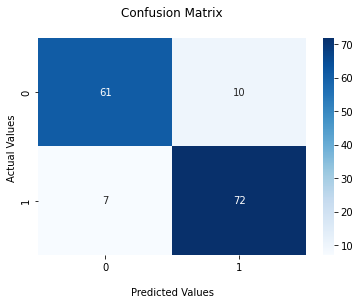

In [15]:
cf_matrix = confusion_matrix(y_test, y_pred >= t)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

##plt.figure(figsize=(7,5))
plt.rcParams['figure.figsize'] = [7, 5]  # re-run this cell to get the correct figure size

plt.show();

<font size="5"> 👏 </font> Como vimos en el Jupyter Notebook anterior, obtuvimos valores de métricas similares a los de los conjuntos de datos de entrenamiento y validación, por lo que no estamos sobreajustadando ('overfitting') y el modelo generaliza bien.

<a href=#toc>Subir a Tabla de Contenidos</a><br>

#### <font color=#ac6240>3.2.2 Aplicación del modelo</font>

Simulemos una nueva paciente con los siguientes datos:

In [16]:
new_patient = {
    'Age': 56,
    'Sex': 'F',
    'ChestPainType': 'ATA', 
    'RestingBP': 130,  
    'Cholesterol': 150, 
    'FastingBS': 'L',
    'RestingECG': 'ST',
    'MaxHR': 115,
    'ExerciseAngina': 'N',
    'Oldpeak': 1.,
    'ST_Slope': 'Flat',
 }

Preparamos los datos de entrada como en la sección <a href=#prep>Preparación de datos</a>:

In [17]:
num_dict = dict()
cat_dict = dict()
    
for (key, value) in new_patient.items():
    if key in numerical:
        num_dict[key] = value
    else:
        cat_dict[key] = value

# DictVect input must be a dict
X_cat = dv.transform(cat_dict) # encode the categorical features

# Scaler input must be a np.array
X_num = np.array(list(num_dict.values())).reshape(1, -1)
X_num = scaler.transform(X_num) # scale the numerical features

# Join both arrays
X = np.column_stack([X_num, X_cat]) 

y aplicamos el modelo:

In [18]:
print()
y_pred = RF.predict_proba(X)[:, 1]
print('Model application to a new patient:')
print()
print("The patient raw score of suffering a hear failure is:", y_pred[0].round(2))
print()
print("With t =", t, "as the decision threshold, is there a risk of suffering a heart failure?", y_pred[0] >= t)


Model application to a new patient:

The patient raw score of suffering a hear failure is: 0.29

With t = 0.4 as the decision threshold, is there a risk of suffering a heart failure? False


<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='xai-app'/>

## <font color=#ac6240>4. Aplicación del modelos de explicabilidad</font>

Una vex tenemos listo el bosque aleatorio, no vamos a cambiarlo ni vamos a cambiar los resutados de sus predicciones. Vamos a aplicar metodos de XAI sobre el conjunto de datos de validación.

<a name='xai-per'/>

### <font color=#ac6240>4.1 Permutacion importance y Partial Dependence Plots</font>

Vamos a preguntarnos lo siguiente: si revolvemos aleatoriamente ('shuffling') los valores de una columna (es decir, una caracteristica o 'feature') de los datos de validación, dejando igual el resto de columnas, influyendo la de la variable de destino o 'target', cómo se ve afectada la métrica de rendimiento? Parece lógico pensar en estos dos escenarios:
+ la métrica sufrirá especialmente cuando reordenemos (es decir, metamos ruido) a los datos de una columna relevante, y 
+ la métrica ni notará si revolvemos una característica o 'feature' insignificante para la predicción.
Vamos aplicarlo. Cada característica es revuelta varias veces y se hace la media de las impostancias resultantes para obtener una idea de la robusted del resultado. Eso sí, este metodo solo vale para datos tabulares. 

Usaremos el la función `permutation_importance` de Sckit-learn y usaremos la métrica 'F1-score'. 

In [19]:
metric = make_scorer(f1_score)

result = permutation_importance(RF, X_val, y_val, scoring = metric,
                                n_repeats = 10, random_state = 1)
RF_per_importances = pd.Series(result.importances_mean, index=feature_names)

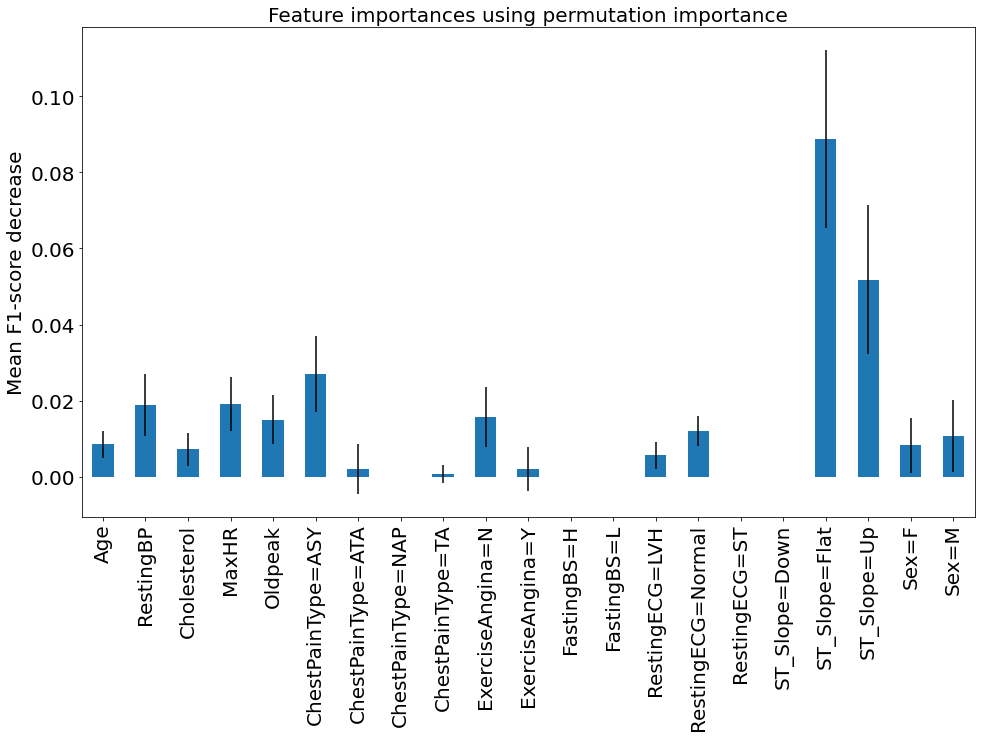

In [20]:
fig, ax = plt.subplots(figsize = (16, 9))
RF_per_importances.plot.bar(yerr=result.importances_std, ax = ax,fontsize = 20)
ax.set_title("Feature importances using permutation importance",fontsize = 20)
ax.set_ylabel("Mean F1-score decrease",fontsize = 20)
plt.show()

Ahora sabemos que la característica 'ST_Slope' (Flat y Up) y 'ChestPainType' son las más relevantes para este bosque aleatorio. Recordamos que en el Jupyter Notebook anterior vimos que 'Oldpeak, y 'MaxHR' eran las características numéricas más relevantes y 'ST_Slope', 'ExerciseAngina' y 'ChestPainType' las características categóricas más relevantes.

Podemos entonces averiguar _cómo_ esas características tan relevantes afectan a las prediciones de nuestro bosque aleatorio. Para eso utilizamos los llamados Partial Dependence Plots. Estos gráficos nos mostrarán el efecto marginal de una o dos 'features' sobre los resultados que nos da nuestro modelo de bosque aleatorio. Eneñan la relación entre esa 'feature' y la variable de destino o 'target', tanto si la dependencia es lineal como si es más compleja. Eso si, nos muestran el efecto medio, 

Para entender cómo este método discierne el efecto de cada 'feature' vamos a empezar considerando una fila de datos, es decir, cogemos los datos de unx paciente al azar. Aplicamos nuestro bosque aleatorio a esx paciente para predecir si está o no en riesgo de sufrir un fallo cardíaco. Pero incrementamos poco a poco el valor de una de las características ('Cholesterol', por ejemplo) y obtenemos una serie de predicciones. En un gráfico colocamos los resultados de estas predicciones en el eje vertical y las correpondientes alteraciones que hicimos de los valores de esa 'feature' en el eje horizontal, de menor a mayor. 

Usaremos la función `PartialDependenceDisplay` de Scikit-learn. Cada línea azul de los graficos muestra la Individual Conditional Expectation (ICE) de unx paciente y la línea discontinua naranja muestra la media.

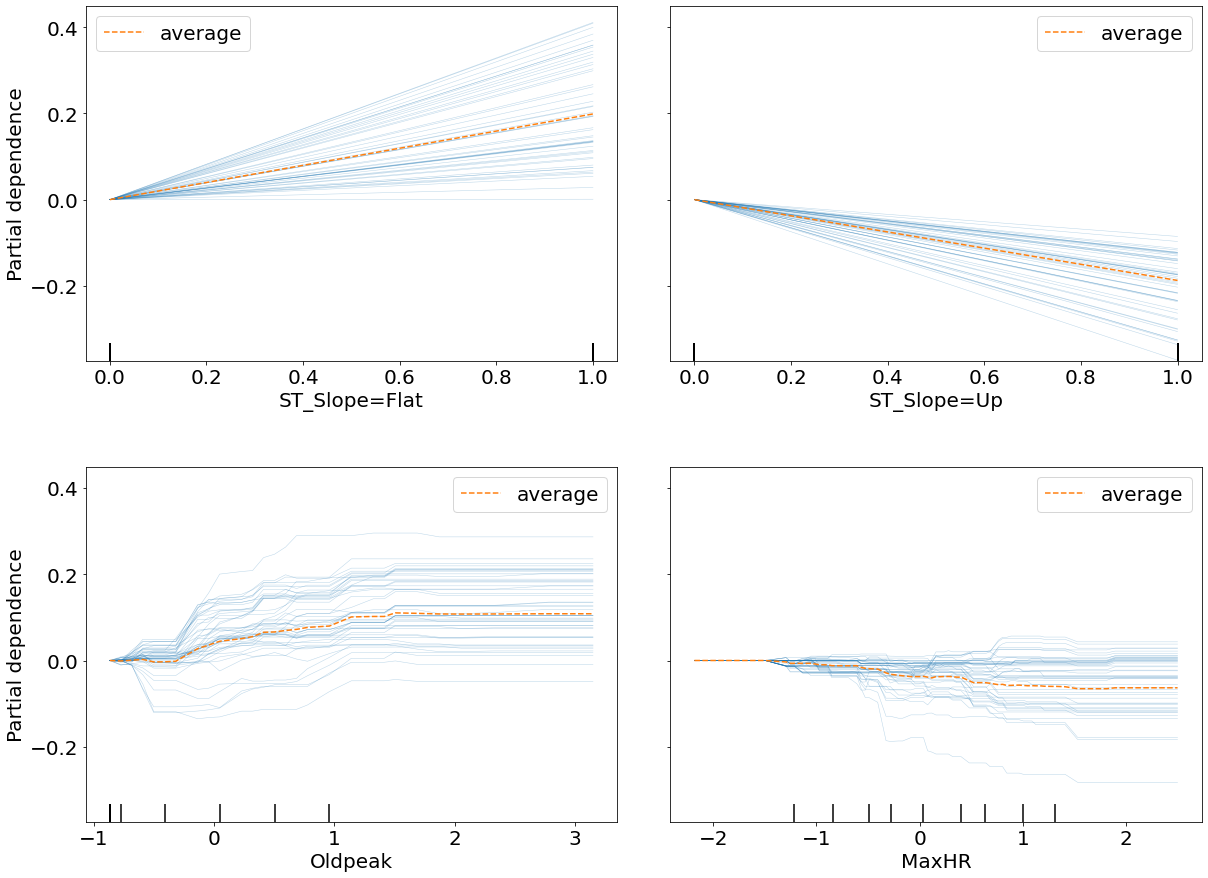

In [46]:
# convert validation data from numpy array to dataframe
df_X_val = pd.DataFrame(X_val,columns= feature_names)

fig, ax = plt.subplots(2,2,figsize=(20, 15))

PDD = PartialDependenceDisplay.from_estimator(
    RF,
    df_X_val,
    features = ['ST_Slope=Flat', 'ST_Slope=Up','Oldpeak', 'MaxHR'], 
    kind = 'both', centered = True, subsample = 50, grid_resolution = 100,
    random_state = 1, ax = ax
)

PDD.figure_.subplots_adjust(hspace=0.3, wspace=0.1)

plt.rcParams['font.size'] = '20' #run this cell twice or more times to get the right fontsize

El eje vertical indica el cambio en la predicción del bosque aleatorio orginado por los incrementos que hacemos en los valores de la 'feature' (medido respecto al valor mas a la izquierda del rango de los posibles valores de esa 'feature').

Como 'ST_Slope' es una variable categórica sólo vemos una dependencia lineal. En el resto de variables, la dependenica también es monotónica. Las lineas azules, los ICE, muestran algún 'outlier'. Por ejemplo, en el último gráfico vemos unx paciente particularmente muy afectadx por los cambios en su 'MaxHR': su 'probabilidad' de fallo cardíaco cae significativamente al aumentar sus valores de 'MaxHR'. Los ICE en cambio no muestran claras excepciones, parece que la tendencia en el comportamiento es similar la todxs lxs pacientes (todxs muestran la misma monotonicidad, sea creciente o decreciente).

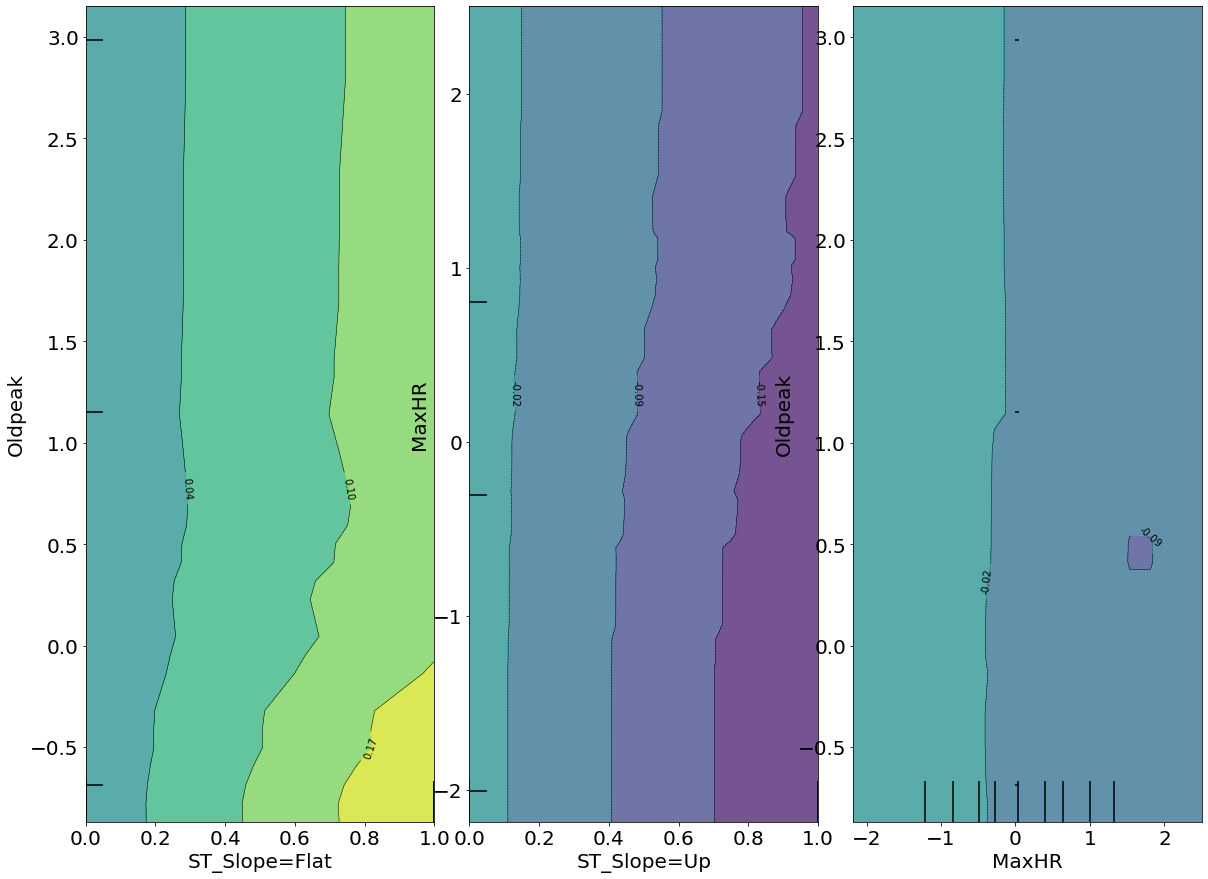

In [48]:
fig, ax = plt.subplots(1,3,figsize=(20, 15))

PDD = PartialDependenceDisplay.from_estimator(
    RF,
    df_X_val,
    features = [('ST_Slope=Flat','Oldpeak'), ('ST_Slope=Up','MaxHR'),('MaxHR','Oldpeak')], 
    kind = 'average', centered = True, subsample = 50, grid_resolution = 100,
    random_state = 1, ax = ax
)

PDD.figure_.subplots_adjust(hspace=0.3, wspace=0.1)

plt.rcParams['font.size'] = '20' #run this cell twice or more times to get the right fontsize

SHAAAAP

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html

Vamos a ver los Partial Dependence Plots de las variables numéricas más relevantes:

In [ ]:
for item in some_categorical:
    pdp_goals = pdp.pdp_isolate(model = RF, dataset = df_X_val, 
                                model_features = feature_names, 
                                feature = item)
    # plot
    pdp.pdp_plot(pdp_goals, item, figsize = (15,4))
    plt.show()


In [ ]:
some_categorical = ['Oldpeak', 'MaxHR']

# define subplot grid
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
plt.subplots_adjust(hspace=0.5)
#fig.suptitle("Daily closing prices", fontsize=18, y=0.95)

# loop 
for item, ax in zip(some_categorical,axs):
    pdp_goals = pdp.pdp_isolate(model = RF, dataset = df_X_val, 
                                model_features = feature_names, 
                                feature = item)

    # plot
    pdp.pdp_plot(pdp_goals, item, ax=ax)

plt.show()




#for item in some_categorical:
#    pdp_goals = pdp.pdp_isolate(model = RF, dataset = df_X_val, 
#                                model_features = feature_names, 
#                                feature = item)

    # plot
#    pdp.pdp_plot(pdp_goals, item)
#    plt.show()

In [ ]:
plt.plot(df_X_val['Oldpeak'])

<font size="5"> 🏋🏾‍♀️  </font> Gracias por tu atención y hasta pronto!